# Tutorial: Building a DVC repo for an ML workflow

This guide demonstrates the construction of a DVC repository that is tailored to a machine learning pipeline with infrastructure-as-code principles. The example pipeline will perform dataset preprocessing and machine learning training/inference stages. The key concepts we will explore include:

 * Repository-wide configuration, managed via repo-policies
 * Stage-wise configuration, controlled through stage-policies
 * The creation of an app-policy that derives its parameters from the previous two, leading to a concrete instantiation of the corresponding DVC stages

It is important to note that stage and app policies cover multiple logically connected DVC stages, not just a single stage.  For example, a machine learning app policy usually encapsulates both a training and inference stage of an ML model.

In the context of an ML workflow, we'll cover how to
 * Handle manual and automated preprocessing steps in DVC
 * Set up an ML stage using these techniques
 * Execute the stages

To streamline this tutorial, we will not be using `EncFS`, containers and SLURM. The focus will primarily be on the stage and app policies as well as on the file hierarchy. All additional features can conveniently be activated later via modifications to the app policy.

## Initializing the DVC repository
We first import the depencies for the tutorial.

In [1]:
import os

In [2]:
from IPython.display import SVG  # test_ml_tutorial: skip

Create a new directory `data/v0` for the DVC root and change to it.

In [3]:
os.chdir('data/v0')

Initialize a `plain` DVC repository using the command

In [4]:
!dvc_init_repo . plain

2023-07-25 15:22:22,253 DEBUG: v0.1.dev8866+gd72e04c, CPython 3.8.10 on Linux-5.15.0-76-generic-x86_64-with-glibc2.29
2023-07-25 15:22:22,253 DEBUG: command: /home/lukasd/src/mitraccel/async-encfs-dvc/venv/bin/dvc init --subdir --verbose
2023-07-25 15:22:22,494 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvc/config.local' to gitignore file.
2023-07-25 15:22:22,495 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvc/tmp' to gitignore file.
2023-07-25 15:22:22,495 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvc/cache' to gitignore file.
2023-07-25 15:22:22,495 DEBUG: Removing '/var/tmp/dvc/repo/2ee751a7fb5029083b3bccfd7ff622fb'
2023-07-25 15:22:22,520 DEBUG: Staging files: {'/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvc/.gitignore', '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvcignore', '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0/.dvc/config'}
In

The DVC repo has been initialized with repo and stage policies available under `.dvc_policies`.

In [5]:
!tree .dvc_policies

.dvc_policies
├── repo
│   └── dvc_root.yaml
└── stages
    ├── dvc_config.yaml
    ├── dvc_etl.yaml
    ├── dvc_in.yaml
    ├── dvc_ml_inference.yaml
    ├── dvc_ml_training.yaml
    └── dvc_simulation.yaml

2 directories, 7 files


## Establishing the input dataset
Our pipeline will be based on a dataset labeled `ml_dataset` that we assume to be split into training, test, and inference. Each of these has specific subsets and we will utilize a subset labeled `ex1` for all of them (although this could be chosen differently for each of them). We populate the repository with this input data and track it with DVC by executing the following commands:

In [6]:
%%bash
mkdir -p in/ml_dataset_v1/{training,test,inference}/original/ex1
touch in/ml_dataset_v1/{training,test,inference}/original/ex1/in.dat
for d in in/ml_dataset_v1/{training,test,inference}/original; do
    cd $d && dvc add ex1 && cd -
done

⠋ Checking graph



To track the changes with git, run:

	git add .gitignore ex1.dvc

To enable auto staging, run:

	dvc config core.autostage true
/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0


⠋ Checking graph



To track the changes with git, run:

	git add ex1.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true
/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0


⠋ Checking graph



To track the changes with git, run:

	git add ex1.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true
/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0


The resulting file hierarchy looks as follows:

In [7]:
!tree in

in
└── ml_dataset_v1
    ├── inference
    │   └── original
    │       ├── ex1
    │       │   └── in.dat
    │       └── ex1.dvc
    ├── test
    │   └── original
    │       ├── ex1
    │       │   └── in.dat
    │       └── ex1.dvc
    └── training
        └── original
            ├── ex1
            │   └── in.dat
            └── ex1.dvc

10 directories, 6 files


Before moving to the definition of preprocessing stages, we define execution labels based on timestamps for the subsequent DVC stages. In a real-world application, the timestamps would usually be generated on the fly when creating the DVC stage.

In [8]:
%env ETL_TRAIN_RUN_LABEL=ex1-20230713-083624
%env ETL_INF_RUN_LABEL=ex1-20230713-083812
%env ETL_TEST_RUN_LABEL=ex1-20230713-083951
%env ML_TRAIN_RUN_LABEL=ex1-20230713-090119
%env ML_INF_RUN_LABEL=ex1-20230713-121007

env: ETL_TRAIN_RUN_LABEL=ex1-20230713-083624
env: ETL_INF_RUN_LABEL=ex1-20230713-083812
env: ETL_TEST_RUN_LABEL=ex1-20230713-083951
env: ML_TRAIN_RUN_LABEL=ex1-20230713-090119
env: ML_INF_RUN_LABEL=ex1-20230713-121007


## Constructing the preprocessing stage
The next step involves setting up the preprocessing stages. For the purpose of the demonstration, we will assume that this consists of a simple copy operation for each of the training, test and inference data. In a real-world scenario, this can be replaced by any other operation as required.

In particular, a preprocessing stage may also involve manual user interaction (e.g. in a GUI) that cannot be reproduced from the command line and, hence, is executed outside of DVC. We will cover this case for the training data, whereas we use DVC-reproducible commands for the preprocessing of the other datasets.

### Manual preprocessing
To implement a manual preprocessing step for the `training` data, we create a DVC stage with a no-op command that is `frozen` in order not to be reproduced by `dvc repro` as configured in the app policy `dvc_app.yaml`. Nevertheless, the data dependencies of this stage are tracked in DVC via an ETL stage policy `dvc_etl.yaml`.

To create this stage, run the following command:

In [9]:
%%bash
dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml --stage manual_train \
    --run-label ${ETL_TRAIN_RUN_LABEL} --input-etl ex1 --input-etl-file in.dat

Added stage 'app_prep_v1_manual_train_ex1-20230713-083624' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml .gitignore

To enable auto staging, run:

	dvc config core.autostage true
Modifying stage 'app_prep_v1_manual_train_ex1-20230713-083624' in 'dvc.yaml'
Not using SLURM or MPI in this DVC stage.
Writing DVC stage to in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624
Freezing stage for execution outside dvc - run 'dvc commit app_prep_v1_manual_train_ex1-20230713-083624' when outputs are done.


To obtain the output data, the manual operation can now be performed. For this purpose, we inspect the newly created `dvc.yaml`. To perform a copy operation, we move the data in `deps` to the `output` directory in `outs`. As described above, in a real application, this step would typically be performed in a GUI app with some user interaction.

In [10]:
%%bash
cd in/ml_dataset_v1/training/app_prep_v1/manual/${ETL_TRAIN_RUN_LABEL}
cat dvc.yaml
cp ../../../original/ex1/* output/
cd -

stages:
  app_prep_v1_manual_train_ex1-20230713-083624:
    desc: Generated with venv/bin/dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml
      --stage manual_train --run-label ex1-20230713-083624 --input-etl ex1 --input-etl-file
      in.dat at commit 9b25c0cefc87b7b60a2b956f5d64ed9a98f66372
    cmd: if (set -o pipefail) 2>/dev/null; then set -o pipefail; fi; mkdir -p output
      && bash -c "true --etl-input ../../../original/ex1/in.dat --etl-output output"
      2>&1 | tee output/stage_out.log
    deps:
    - ../../../original/ex1
    outs:
    - output
    frozen: true
/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0


In [11]:
%%bash
tree in/ml_dataset_v1/training/app_prep_v1/manual/${ETL_TRAIN_RUN_LABEL}

in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624
├── dvc_app.yaml
├── dvc.yaml
└── output
    └── in.dat

1 directory, 3 files


Once the manual operation has completed and the output directory is populated with data, we can commit it with:

In [12]:
%%bash
dvc commit --force in/ml_dataset_v1/training/app_prep_v1/manual/${ETL_TRAIN_RUN_LABEL}/dvc.yaml

Generating lock file 'in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624/dvc.lock'
Updating lock file 'in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624/dvc.lock'


### Automated preprocessing
In contrast, for the test and inference datasets, we will assume that the preprocessing is fully automated. These stages can be created and executed with:

In [13]:
%%bash

# test-data
dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml --stage auto_test \
    --run-label ${ETL_TEST_RUN_LABEL} --input-etl ex1 --input-etl-file in.dat
dvc repro in/ml_dataset_v1/test/app_prep_v1/auto/${ETL_TEST_RUN_LABEL}/dvc.yaml

Added stage 'app_prep_v1_auto_test_ex1-20230713-083951' in 'dvc.yaml'

To track the changes with git, run:

	git add .gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Not using SLURM or MPI in this DVC stage.
Writing DVC stage to in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951
'in/ml_dataset_v1/test/original/ex1.dvc' didn't change, skipping
Running stage 'in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/dvc.yaml:app_prep_v1_auto_test_ex1-20230713-083951':
> if (set -o pipefail) 2>/dev/null; then set -o pipefail; fi; mkdir -p output && bash -c "$(git rev-parse --show-toplevel)/examples/app_prep/prep.sh --etl-input ../../../original/ex1/in.dat --etl-output output" 2>&1 | tee output/stage_out.log
+ cp ../../../original/ex1/in.dat output
Generating lock file 'in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/dvc.lock'
Updating lock file 'in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/dvc.lock'

To track the changes 

In [14]:
%%bash

# inference-data
dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml --stage auto_inf \
    --run-label ${ETL_INF_RUN_LABEL} --input-etl ex1 --input-etl-file in.dat
dvc repro in/ml_dataset_v1/inference/app_prep_v1/auto/${ETL_INF_RUN_LABEL}/dvc.yaml

Added stage 'app_prep_v1_auto_inf_ex1-20230713-083812' in 'dvc.yaml'

To track the changes with git, run:

	git add .gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Not using SLURM or MPI in this DVC stage.
Writing DVC stage to in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812
'in/ml_dataset_v1/inference/original/ex1.dvc' didn't change, skipping
Stage 'in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812/dvc.yaml:app_prep_v1_auto_inf_ex1-20230713-083812' is cached - skipping run, checking out outputs
Generating lock file 'in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812/dvc.lock'
Updating lock file 'in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812/dvc.lock'

To track the changes with git, run:

	git add in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812/dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use `dvc push` to send your updates to remote storage.


Execution can also be deferred to the ML stages, where it will be triggered as a dependency.

## Creating the Machine Learning stage
Lastly, we will establish a rudimentary structure for a machine learning application that utilizes the preprocessed data:


In [15]:
%%bash
mkdir -p app_ml/ml_dataset_v1/model_name_v2/{training,inference,config}

We encapsulate hyperparameters and model architecture specifications that are fixed during training in a file `hp.yaml`.

In [16]:
%%bash
mkdir -p app_ml/ml_dataset_v1/model_name_v2/config/ex1-config/output
touch app_ml/ml_dataset_v1/model_name_v2/config/ex1-config/output/hp.yaml
cd app_ml/ml_dataset_v1/model_name_v2/config && dvc add ex1-config && cd -
tree app_ml

⠋ Checking graph



To track the changes with git, run:

	git add ex1-config.dvc .gitignore

To enable auto staging, run:

	dvc config core.autostage true
/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v0
app_ml
└── ml_dataset_v1
    └── model_name_v2
        ├── config
        │   ├── ex1-config
        │   │   └── output
        │   │       └── hp.yaml
        │   └── ex1-config.dvc
        ├── inference
        └── training

7 directories, 2 files


Following this, we can set up the machine learning training and inference stages. Where necessary, we can obtain completion suggestions with `--show-opts`.


In [17]:
%%bash
dvc_create_stage --app-yaml ../../app_ml/dvc_app.yaml --stage training \
    --run-label ${ML_TRAIN_RUN_LABEL} \
    --input-config ex1-config --input-config-file hp.yaml --input-training ${ETL_TRAIN_RUN_LABEL} --input-test ${ETL_TEST_RUN_LABEL}
dvc_create_stage --app-yaml ../../app_ml/dvc_app.yaml --stage inference \
    --run-label ${ML_INF_RUN_LABEL} \
    --input-config ex1-config --input-config-file hp.yaml --input-training ${ML_TRAIN_RUN_LABEL} --input-inference ${ETL_INF_RUN_LABEL}

Added stage 'app_ml_ml_dataset_v1_model_name_v2_training_ex1-20230713-090119' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml .gitignore

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to app_ml/ml_dataset_v1/model_name_v2/training/ex1-20230713-090119
Added stage 'app_ml_ml_dataset_v1_model_name_v2_inference_ex1-20230713-121007' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml .gitignore

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to app_ml/ml_dataset_v1/model_name_v2/inference/ex1-20230713-121007


## Running the pipeline
These stages can be inspected with:

In [18]:
%%bash
dvc dag --dot app_ml/ml_dataset_v1/model_name_v2/inference/${ML_INF_RUN_LABEL}/dvc.yaml | tee app_ml/ml_dataset_v1/model_name_v2/inference/${ML_INF_RUN_LABEL}/dvc_dag.dot
if [[ $(command -v dot) ]]; then
    dot -Tsvg app_ml/ml_dataset_v1/model_name_v2/inference/${ML_INF_RUN_LABEL}/dvc_dag.dot > app_ml/ml_dataset_v1/model_name_v2/inference/${ML_INF_RUN_LABEL}/dvc_dag.svg
fi

strict digraph  {
"app_ml/ml_dataset_v1/model_name_v2/config/ex1-config.dvc";
"app_ml/ml_dataset_v1/model_name_v2/training/ex1-20230713-090119/dvc.yaml:app_ml_ml_dataset_v1_model_name_v2_training_ex1-20230713-090119";
"app_ml/ml_dataset_v1/model_name_v2/inference/ex1-20230713-121007/dvc.yaml:app_ml_ml_dataset_v1_model_name_v2_inference_ex1-20230713-121007";
"in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624/dvc.yaml:app_prep_v1_manual_train_ex1-20230713-083624";
"in/ml_dataset_v1/training/original/ex1.dvc";
"in/ml_dataset_v1/inference/app_prep_v1/auto/ex1-20230713-083812/dvc.yaml:app_prep_v1_auto_inf_ex1-20230713-083812";
"in/ml_dataset_v1/inference/original/ex1.dvc";
"in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/dvc.yaml:app_prep_v1_auto_test_ex1-20230713-083951";
"in/ml_dataset_v1/test/original/ex1.dvc";
"app_ml/ml_dataset_v1/model_name_v2/config/ex1-config.dvc" -> "app_ml/ml_dataset_v1/model_name_v2/training/ex1-20230713-090119/dvc.yaml:app_ml_ml_dataset

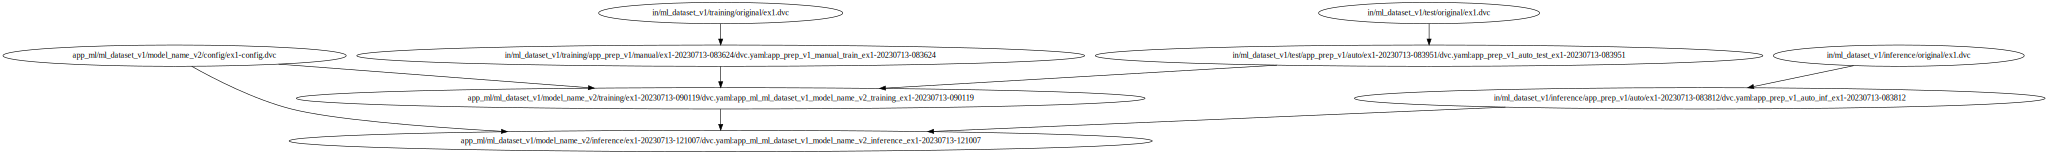

In [19]:
dvc_dag_img = 'app_ml/ml_dataset_v1/model_name_v2/inference/' + os.environ['ML_INF_RUN_LABEL'] + '/dvc_dag.svg'  # test_ml_tutorial: skip
if os.path.exists(dvc_dag_img):  # test_ml_tutorial: skip
    display(SVG(filename=dvc_dag_img))  # test_ml_tutorial: skip

And finally executed with:

In [20]:
%%bash
dvc repro app_ml/ml_dataset_v1/model_name_v2/inference/${ML_INF_RUN_LABEL}/dvc.yaml

'app_ml/ml_dataset_v1/model_name_v2/config/ex1-config.dvc' didn't change, skipping
'in/ml_dataset_v1/test/original/ex1.dvc' didn't change, skipping
Stage 'in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/dvc.yaml:app_prep_v1_auto_test_ex1-20230713-083951' didn't change, skipping


Stage 'in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624/dvc.yaml:app_prep_v1_manual_train_ex1-20230713-083624' didn't change, skipping
Running stage 'app_ml/ml_dataset_v1/model_name_v2/training/ex1-20230713-090119/dvc.yaml:app_ml_ml_dataset_v1_model_name_v2_training_ex1-20230713-090119':
> if (set -o pipefail) 2>/dev/null; then set -o pipefail; fi; mkdir -p output && bash -c "time mpiexec -np 2 $(git rev-parse --show-toplevel)/examples/app_ml/training.sh --training-input ../../../../../in/ml_dataset_v1/training/app_prep_v1/manual/ex1-20230713-083624/output --test-input ../../../../../in/ml_dataset_v1/test/app_prep_v1/auto/ex1-20230713-083951/output --config ../../config/ex1-config/output/hp.yaml --training-output output" 2>&1 | tee output/stage_out.log
training.sh: cd /src/app
training.sh: source venv/bin/activate
training.sh: cd /src/app
training.sh: source venv/bin/activate
++ dirname /home/lukasd/src/mitraccel/async-encfs-dvc/examples/app_ml/training.sh
++ dirname /h

In [21]:
!tree in app_ml

in
└── ml_dataset_v1
    ├── inference
    │   ├── app_prep_v1
    │   │   └── auto
    │   │       └── ex1-20230713-083812
    │   │           ├── dvc_app.yaml
    │   │           ├── dvc.lock
    │   │           ├── dvc.yaml
    │   │           └── output
    │   │               ├── in.dat
    │   │               └── stage_out.log
    │   └── original
    │       ├── ex1
    │       │   └── in.dat
    │       └── ex1.dvc
    ├── test
    │   ├── app_prep_v1
    │   │   └── auto
    │   │       └── ex1-20230713-083951
    │   │           ├── dvc_app.yaml
    │   │           ├── dvc.lock
    │   │           ├── dvc.yaml
    │   │           └── output
    │   │               ├── in.dat
    │   │               └── stage_out.log
    │   └── original
    │       ├── ex1
    │       │   └── in.dat
    │       └── ex1.dvc
    └── training
        ├── app_prep_v1
        │   └── manual
        │       └── ex1-20230713-083624
        │           ├── dvc_app.yaml
        │           ├── dvc.loc